## <div align="center"> Client Case: OG&Gym</div>
## <div align="center"> Analytics in Business</div>
### <div align="center"> Appendix</div>

<div align="center">25/1/2021</div>

<br><div align="center"> By Group A3: </div>
<div align="center"> Jiaqi Chen, Yuxi Fu, Jiaxuan Lyu, Maria Tsotalou, Qian Zhang </div>

In [88]:
import pandas as pd
import numpy as np
import math

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
#%run ....../Appendix.ipynb

In [90]:
data_path = "./data/"

In [91]:
### Initial data loading 
subscriptions = pd.read_csv(data_path + 'subscriptionsdataFINAL.csv') 

In [92]:
visitation_part1 = pd.read_csv(data_path +'visitationdataPART1.csv') 
visitation_part2 = pd.read_csv(data_path +'visitationdataPART2.csv') 

### Revenue 

 Code for total revenues plot

In [ ]:
#Membership net flow
def calculate_revenue_flexible(Date,net_member):
    date_while_price_changed = pd.Timestamp('2016-01-01') 
    if Date < date_while_price_changed:
        return net_member * 25.99
    elif Date >= date_while_price_changed:
        return net_member * 30.99
    
def calculate_revenue_standard(Date,net_member):
    date_while_price_changed = pd.Timestamp('2016-01-01') 
    if Date < date_while_price_changed:
        return net_member * 20.99
    elif Date >= date_while_price_changed:
        return net_member * 26.99 

def data_manipulation_for_revenue(subscriptions):
    df = subscriptions.copy()
    
    df['Join Date'] =  pd.to_datetime(df['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
    df['Join_year'] = pd.DatetimeIndex(df['Join Date']).year
    df['End Date'] =  pd.to_datetime(df['End Date'].str.upper(), format='%b-%y', yearfirst=False)
    
    member_joined_data = df.groupby(['Join Date','Subscription Type']).size().reset_index(name='Number_of_member_joined')
    member_joined_data = member_joined_data.rename(columns={'Join Date': "Date"})

    member_left_data = df.groupby(['End Date','Subscription Type']).size().reset_index(name='Number_of_member_left')
    member_left_data=member_left_data.rename(columns={'End Date': "Date"})
    member_left_data['Date']=member_left_data['Date'] + pd.DateOffset(months=1)

    member_data = pd.merge(member_joined_data,member_left_data,on = ['Subscription Type','Date'],how='outer').sort_index().replace({np.nan:0})
    member_data['net_member'] = member_data['Number_of_member_joined'] - member_data['Number_of_member_left'] 
    member_data = member_data.drop(columns = ['Number_of_member_joined', 'Number_of_member_left'])

    Members_per_subscription = pd.DataFrame(member_data.groupby(['Date', 'Subscription Type']).sum())
    Cumulative_Members = Members_per_subscription.cumsum().reset_index()
    Cumulative_Members = Cumulative_Members.rename(columns={"net_member": "Cumulative members"}) 
    
    Cumulative_Members_revenue = Cumulative_Members.copy()
    Cumulative_Members_revenue['Flexible_revenue'] = Cumulative_Members[Cumulative_Members["Subscription Type"]=="Flexible"].apply(lambda row: calculate_revenue_flexible(row['Date'], row['Cumulative members']),axis=1)
    Cumulative_Members_revenue['Standard_revenue'] = Cumulative_Members[Cumulative_Members["Subscription Type"]=="Standard"].apply(lambda row: calculate_revenue_standard(row['Date'], row['Cumulative members']),axis=1)
    
    Cumulative_Members_revenue_total = Cumulative_Members_revenue.copy()
    Cumulative_Members_revenue_total = Cumulative_Members_revenue_total.groupby('Date').sum()
    Cumulative_Members_revenue_total['Total revenue'] = Cumulative_Members_revenue_total['Flexible_revenue'] 
    + Cumulative_Members_revenue_total['Standard_revenue']

    Cumulative_Members_revenue_total['Revenue_growth'] = Cumulative_Members_revenue_total['Total revenue'].pct_change()

    Cumulative_Members_revenue_total.reset_index(inplace=True)
    #Cumulative_revenue_growth.reset_index(inplace=True)

    Cumulative_revenue_yearly = Cumulative_Members_revenue_total.copy()
    Cumulative_revenue_yearly = Cumulative_revenue_yearly.drop(columns=['Cumulative members']) 

    Cumulative_revenue_yearly['year'] = pd.DatetimeIndex(Cumulative_revenue_yearly['Date']).year
    Cumulative_revenue_yearly = pd.DataFrame(Cumulative_revenue_yearly.groupby('year').sum() )
    Cumulative_revenue_yearly = Cumulative_revenue_yearly.drop([2019])
    Cumulative_revenue_yearly['Revenue_growth'] = Cumulative_revenue_yearly['Total revenue'].pct_change()
    Cumulative_revenue_yearly.reset_index(inplace=True)

    return Cumulative_Members_revenue_total, Cumulative_revenue_yearly

In [ ]:
Cumulative_Members_revenue_total, Cumulative_revenue_yearly = data_manipulation_for_revenue(subscriptions)

In [ ]:
def plot_monthly_revenue():
    plt.figure(figsize=(10,10))
    plt.plot(Cumulative_Members_revenue_total['Date'], Cumulative_Members_revenue_total['Total revenue'])
    plt.title('Revenue Over Time')
    plt.ylabel('Revenue')
    plt.xlabel('Date')
    plt.axvline(x=datetime.strptime('2016-01-01', '%Y-%m-%d'), linestyle='--', color = 'r')
    plt.show()
                                                                                        
plot_monthly_revenue()

In [ ]:
def plot_growth_yearly_mothly():
    plt.figure(figsize=(10,10))
    plt.plot(Cumulative_Members_revenue_total['Date'], Cumulative_Members_revenue_total['Revenue_growth'])
    plt.title('Revenue Growth over Time')
    plt.ylabel('Revenue')
    plt.xlabel('Date')
    plt.axvline(x=datetime.strptime('2016-01-01', '%Y-%m-%d'), linestyle='--', color = 'r')
    plt.show()
                                                                         
plot_growth_yearly_mothly()

In [ ]:
def plot_growth_yearly_revenue():
    plt.figure(figsize=(10,10))
    plt.plot(Cumulative_revenue_yearly['year'], Cumulative_revenue_yearly['Revenue_growth'])
    plt.title('Total Revenue Growth Over years')
    plt.ylabel('Revenue')
    plt.xlabel('Year')
    plt.axvline(x=2016, linestyle='--', color = 'r')
    plt.show()

plot_growth_yearly_revenue()    

In [ ]:
def plot_bar_yearly_revenue():
    r =  np.arange(2009,2019)
    Total_revenue = Cumulative_revenue_yearly['Total revenue']
    plt.ylabel('Pound')
    plt.bar(r, Total_revenue)
    plt.title('Yearly Revenue')
plot_bar_yearly_revenue()

### Churn

In [46]:
def add_count(join_date, duration, dates, members_count):
    index = (dates == join_date).argmax()
    
    for i in range(index,index + duration+1):
        members_count[i] = members_count[i] +1 
    
    return members_count

In [48]:
##create list with count of members in each month
def basic_data_manipulation_for_churn(subscriptions):

    #convert the join and end date to_date
    subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
    subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)
    
    date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
    date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
    dates = pd.date_range(date_min, date_max, freq = 'MS')

    ##we need to know each month kow many activemembers we have to calculate the churn 
    ##create the dataframe to help us calculate it
    customers_total = pd.DataFrame({'Date':dates})

    ##add total month membership in dataframe subscriptions
    subscriptions['Duration'] = np.where(subscriptions['End Date'].isna(), 
                                         (date_max - subscriptions['Join Date']), 
                                         (subscriptions['End Date'] - subscriptions['Join Date']) )
    ##convert the difference in months
    subscriptions['Duration'] = (subscriptions['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
    
    return(subscriptions, dates)
    
    
def create_list_count_members_each_month(subsc_data):
  
    subscriptions  = subsc_data.copy()
    subscriptions, dates = basic_data_manipulation_for_churn(subscriptions)
    
    members_count =  [0] * len(dates)
    subscriptions.apply(lambda row: add_count(row['Join Date'], row['Duration'],
                                              dates, members_count), axis=1)
    customers_total = pd.DataFrame()
    customers_total['Date'] = dates
    customers_total['Members'] = members_count


    ## members join 
    join_frame = subscriptions.groupby(['Join Date']).count()['CustomerID'].reset_index()
    join_frame = join_frame.rename(columns={'Join Date':'Date','CustomerID':'New Members' })
    customers_total = pd.merge(customers_total, join_frame, on = 'Date', how='outer')
    customers_total

    ##calulate membership growth =  number of new members subscription / total members
    customers_total['Membership Growth']= customers_total['New Members'] / (customers_total['Members'] - customers_total['New Members'])
    customers_total['Membership Growth'] =  customers_total['Membership Growth'].replace([np.inf, -np.inf], np.nan) 
    #customers_total

    ## members leave 
    end_frame = subscriptions.groupby(['End Date']).count()['CustomerID'].reset_index()
    end_frame = end_frame.rename(columns={'End Date':'Date','CustomerID':'Cancellations' })
    customers_total = pd.merge(customers_total, end_frame, on = 'Date', how='outer')
    #customers_total

    ##calulate churn =  number of ending subscription / total members
    customers_total['Churn']= customers_total['Cancellations'] / customers_total['Members']

    return customers_total

customers_total = create_list_count_members_each_month(subscriptions)

NameError: name 'c' is not defined

In [ ]:
#Churn rate vs Time Graph
def plot_churn_total():
    plt.figure(figsize=(10,10))
    plt.plot(customers_total['Date'], customers_total['Churn'])
    plt.title('Churn rate Over Time')
    plt.ylabel('Churn rate')
    plt.xlabel('Date')
    plt.axvline(x=datetime.strptime('2016-01-01', '%Y-%m-%d'), linestyle='--', color = 'r')
    plt.show()
plot_churn_total()

In [ ]:
#Members number vs Time Graph
def plot_members_total():
    plt.figure(figsize=(10,10))
    plt.plot(customers_total['Date'], customers_total['Members'])
    plt.title('Members\' number Over Time')
    plt.ylabel('Members')
    plt.xlabel('Date')
    plt.axvline(x=datetime.strptime('2016-01-01', '%Y-%m-%d'), linestyle='--', color = 'r')
    plt.show()
plot_members_total()

In [ ]:
#Members number vs Time Graph
def plot_members_growth_total():
    plt.figure(figsize=(10,10))
    plt.plot(customers_total['Date'], customers_total['Membership Growth'])
    plt.title('Membership Growth Over Time')
    plt.ylabel('Membership Growth')
    plt.xlabel('Date')
    plt.axvline(x=datetime.strptime('2016-01-01', '%Y-%m-%d'), linestyle='--', color = 'r')
    plt.show()
plot_members_growth_total()

### Churn per population segments

In [11]:
#Churn population breakdown
def get_members_churn_growth(column_name, traits, subsc_data ):
   
    subscriptions  = subsc_data.copy()
    subscriptions, dates = basic_data_manipulation_for_churn(subscriptions)

    members_count_trait = {trait:([0]*len(dates))  for trait in traits}
    subscriptions_pertrait = subscriptions.groupby(subscriptions[column_name])
    for trait in traits:
        subscriptions_pertrait.get_group(trait).apply(lambda row : add_count(row['Join Date'], row['Duration'],
                                                       dates, members_count_trait[trait]), axis=1 )

    

    members_per_trait = pd.DataFrame({'Date':dates,column_name:traits[0], 'Members':members_count_trait[traits[0]]})

    for trait in traits[1:]:
        trait_list = [trait]*len(dates);
        trait_df = pd.DataFrame({'Date':dates, column_name:trait_list, 'Members':members_count_trait[trait]})
        members_per_trait = pd.merge(members_per_trait, trait_df, on = ['Date',column_name,'Members'], how='outer')

    members_per_trait['Members'] = members_per_trait['Members'].replace(0,np.nan)
    #members_per_trait.to_csv(r'members_per_trait.csv')

    ## members join per trait
    join_frame_trait = subscriptions.groupby(['Join Date', column_name]).count()['CustomerID'].reset_index()
    join_frame_trait = join_frame_trait.rename(columns={'Join Date':'Date','CustomerID':'New Members' })
    members_per_trait = pd.merge(members_per_trait, join_frame_trait, on = ['Date', column_name], how='outer')

    ##calulate membership growth =  number of new members subscription / total members
    members_per_trait['Membership Growth']= members_per_trait['New Members'] / (members_per_trait['Members'] - members_per_trait['New Members'])
    members_per_trait['Membership Growth'] = members_per_trait['Membership Growth'].replace([np.inf, -np.inf], np.nan) 

    ## members leave per trait
    cancel_frame_trait = subscriptions.groupby(['End Date', column_name]).count()['CustomerID'].reset_index()
    cancel_frame_trait = cancel_frame_trait.rename(columns={'End Date':'Date','CustomerID':'Cancellations' })
    members_per_trait = pd.merge(members_per_trait, cancel_frame_trait, on = ['Date',column_name], how='outer')

    ##calulate churn =  number of ending subscription / total members
    members_per_trait['Churn']= members_per_trait['Cancellations'] / members_per_trait['Members']

    return members_per_trait

In [80]:
def plot_all_levels_(traits, members_per_trait, column_name, behaviour):
    plt.figure(figsize=(15,15))  
    for trait in traits:
        df_trait = members_per_trait[members_per_trait[column_name] == trait]
        plt.plot(df_trait["Date"], df_trait[behaviour], label = trait, alpha=0.7)
    plt.legend()

In [81]:
def plot_all_levels_churn(traits, members_per_trait, column_name):
    plot_all_levels_(traits, members_per_trait, column_name, "Churn")

In [55]:
def plot_all_levels_growth(traits, members_per_trait, column_name):
    plot_all_levels_(traits, members_per_trait, column_name, "Membership Growth")

In [79]:
def plot_all_levels_members_proportion(traits, members_per_trait, column_name):
    members_total = members_per_trait.groupby('Date')["Members"].sum().rename("Members_Total").reset_index()
    df = members_per_trait
    df = df.merge(members_total)
    df["Member proportion"] = df["Members"] / df["Members_Total"]

    plt.figure(figsize=(15,15))  
    for trait in traits:
        df_trait = df[df[column_name] == trait]
        plt.plot(df_trait["Date"], df_trait["Member proportion"], label = trait, alpha=0.7)
    plt.legend()

In [ ]:
#gender trait
def get_gender_levels(subscriptions):
    genders = subscriptions.Gender.unique()
    members_per_gender = get_members_churn_growth('Gender', genders, subscriptions)
    return (genders, members_per_gender)

def plot_churn_by_gender():
    genders, members_per_gender = get_gender_levels(subscriptions)
    plot_all_levels_churn(genders, members_per_gender, 'Gender')

def plot_proportion_by_gender():
    genders, members_per_gender = get_gender_levels(subscriptions)
    plot_all_levels_members_proportion(genders, members_per_gender, 'Gender')

In [ ]:
plot_churn_by_gender()

In [ ]:
plot_proportion_by_gender()

In [ ]:
#affluence trait
def get_affluence_levels(subscriptions):
    affluence_levels = subscriptions.Affluence.unique().sort()
    members_per_affluence = get_members_churn_growth('Affluence', affluence_levels, subscriptions)
    return (affluence_levels, members_per_affluence)

def plot_churn_by_affluence():
    affluence_levels, members_per_affluence = get_affluence_levels(subscriptions)
    plot_all_levels_churn(affluence_levels, members_per_affluence, 'Affluence')

def plot_proportion_by_affluence():
    affluence_levels, members_per_affluence = get_affluence_levels(subscriptions)
    plot_all_levels_members_proportion(affluence_levels, members_per_affluence, 'Affluence')


In [ ]:
plot_churn_by_affluence()

In [ ]:
plot_proportion_by_affluence()

In [41]:
#Churn population breakdown
def get_members_churn_growth_age(column_name, traits, subsc_data ):
   
    subscriptions  = subsc_data.copy()

    date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
    date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
    dates = pd.date_range(date_min, date_max, freq = 'MS')
    
    members_count_trait = {trait:([0]*len(dates))  for trait in traits}
    subscriptions_pertrait = subscriptions.groupby(subscriptions[column_name])
    for trait in traits:
        subscriptions_pertrait.get_group(trait).apply(lambda row : add_count(row['Join Date'], row['Duration'],
                                                       dates, members_count_trait[trait]), axis=1 )

    

    members_per_trait = pd.DataFrame({'Date':dates,column_name:traits[0], 'Members':members_count_trait[traits[0]]})

    for trait in traits[1:]:
        trait_list = [trait]*len(dates);
        trait_df = pd.DataFrame({'Date':dates, column_name:trait_list, 'Members':members_count_trait[trait]})
        members_per_trait = pd.merge(members_per_trait, trait_df, on = ['Date',column_name,'Members'], how='outer')

    members_per_trait['Members'] = members_per_trait['Members'].replace(0,np.nan)
    #members_per_trait.to_csv(r'members_per_trait.csv')

    ## members join per trait
    join_frame_trait = subscriptions.groupby(['Join Date', column_name]).count()['CustomerID'].reset_index()
    join_frame_trait = join_frame_trait.rename(columns={'Join Date':'Date','CustomerID':'New Members' })
    members_per_trait = pd.merge(members_per_trait, join_frame_trait, on = ['Date', column_name], how='outer')

    ##calulate membership growth =  number of new members subscription / total members
    members_per_trait['Membership Growth']= members_per_trait['New Members'] / (members_per_trait['Members'] - members_per_trait['New Members'])
    members_per_trait['Membership Growth'] = members_per_trait['Membership Growth'].replace([np.inf, -np.inf], np.nan) 

    ## members leave per trait
    cancel_frame_trait = subscriptions.groupby(['End Date', column_name]).count()['CustomerID'].reset_index()
    cancel_frame_trait = cancel_frame_trait.rename(columns={'End Date':'Date','CustomerID':'Cancellations' })
    members_per_trait = pd.merge(members_per_trait, cancel_frame_trait, on = ['Date',column_name], how='outer')

    ##calulate churn =  number of ending subscription / total members
    members_per_trait['Churn']= members_per_trait['Cancellations'] / members_per_trait['Members']

    return members_per_trait

In [49]:
#Age buckets
def add_join_age_col(subscriptions):

    #convert the join and end date to_date
    subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
    subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)
    
    date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
    date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
    dates = pd.date_range(date_min, date_max, freq = 'MS')

    ##we need to know each month kow many activemembers we have to calculate the churn 
    ##create the dataframe to help us calculate it
    customers_total = pd.DataFrame({'Date':dates})

    ##add total month membership in dataframe subscriptions
    subscriptions['Duration'] = np.where(subscriptions['End Date'].isna(), 
                                         (date_max - subscriptions['Join Date']), 
                                         (subscriptions['End Date'] - subscriptions['Join Date']) )
    ##convert the difference in months
    subscriptions['Duration'] = (subscriptions['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
    


    subscriptions['Join Age'] = pd.DatetimeIndex(subscriptions["Join Date"]).year - subscriptions["BirthYear"]
    subscriptions['End Age'] = np.where(subscriptions['End Date'].isna(),
                                ((date_max.year - subscriptions['BirthYear']) ), 
                               (pd.DatetimeIndex(subscriptions['End Date']).year - subscriptions['BirthYear']) ).astype(int)
    return subscriptions
    
def define_age_buckets_and_tier_col(subscriptions):
    
    #subscriptions = add_join_age_col(subscriptions)
        
    subscriptions["Join Age"] = pd.DatetimeIndex(subscriptions["Join Date"]).year - subscriptions["BirthYear"]
    subscriptions['End Age'] = np.where(subscriptions['End Date'].isna(),
                                ((date_max.year - subscriptions['BirthYear']) ), 
                                (pd.DatetimeIndex(subscriptions['End Date']).year - subscriptions['BirthYear']) ).astype(int)

        
    age_limits = [24, 30, 40]
    conditions = [
        (subscriptions['Join Age'] <= age_limits[0]),
        (subscriptions['Join Age'] > age_limits[0]) & (subscriptions['Join Age'] <= age_limits[1]),
        (subscriptions['Join Age'] > age_limits[1]) & (subscriptions['Join Age'] <= age_limits[2]),
        (subscriptions['Join Age'] > age_limits[2])     ]

    # create a list of the values we want to assign for each condition
    values = ['18-24', '25-30', '31-40', '40+']

    
    subscriptions['Join Age Tier'] = np.select(conditions, values)
    subscriptions.groupby('Join Age Tier').count()
    
    return subscriptions    

In [96]:
def plot_churn_by_age(subscriptions):  
    if ('Join Age Tier' not in subscriptions):
        subscriptions = define_age_buckets_and_tier_col(subscriptions)
    age = subscriptions['Join Age Tier'].unique()
    members_per_age = get_members_churn_growth_age('Join Age Tier', age, subscriptions)
    plot_all_levels_churn(age, members_per_age, 'Join Age Tier')

def plot_growth_by_age(subscriptions):  
    if ('Join Age Tier' not in subscriptions):
        subscriptions = define_age_buckets_and_tier_col(subscriptions)
    age = subscriptions['Join Age Tier'].unique()
    members_per_age = get_members_churn_growth_age('Join Age Tier', age, subscriptions)
    plot_all_levels_growth(traits, members_per_trait, column_name)
    
def plot_proportion_by_age(subscriptions):
    if ('Join Age Tier' not in subscriptions):
        subscriptions = define_age_buckets_and_tier_col(subscriptions)
    age = subscriptions['Join Age Tier'].unique()
    members_per_age = get_members_churn_growth('Join Age Tier', age, subscriptions)
    plot_all_levels_members_proportion(age, members_per_age, 'Join Age Tier')

In [ ]:
def plot_growth_by_age_wrap():
     plot_growth_by_age(subscriptions)

In [83]:
def plot_churn_by_age_wrap():
     plot_churn_by_age(subscriptions)

In [70]:
def plot_proportion_by_age_wrap():
    plot_proportion_by_age(subscriptions)

In [84]:
#subscriptions = basic_data_manipulation_for_churn(subscriptions)
plot_churn_by_age_wrap()

#age = subscriptions['Join Age Tier'].unique()
#age = age.sort()
#age

TypeError: 'NoneType' object is not iterable

<Figure size 1080x1080 with 0 Axes>

In [ ]:
#Subscrition trait
def get_subscription_type_levels(subscriptions):
    subc_types = subscriptions['Subscription Type'].unique()
    members_per_subc_types = get_members_churn_growth('Subscription Type', subc_types, subscriptions)
    return (subc_types, members_per_subc_types)

def plot_churn_by_subscription_type():
    subc_types, members_per_subc_types = get_subscription_type_levels(subscriptions)
    plot_all_levels_churn(subc_types, members_per_subc_types, 'Subscription Type')
    
def plot_proportion_by_subscription_type():
    subc_types, members_per_subc_types = get_subscription_type_levels(subscriptions)
    plot_all_levels_members_proportion(subc_types, members_per_subc_types, 'Subscription Type')

In [ ]:
plot_churn_by_subscription_type()

In [ ]:
plot_proportion_by_subscription_type()

## Memebership by segmentation

In [ ]:
def data_manipulation_membership(subscr_data,col_name = ' '):
    
    subscriptions = subscr_data.copy()
   
    subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
    subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)

    date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
    date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
    
    all_dates = pd.date_range(date_min, date_max, freq = 'Y')
    
    subscriptions['End Date'] = subscriptions['End Date'].fillna(date_max)
    subscriptions[all_dates] = pd.concat([((subscriptions['Join Date'] <= i) & (i <= subscriptions['End Date'])).astype(int) for i in all_dates], axis=1)
    
    if col_name!='':
        ds = subscriptions.groupby(col_name)[all_dates].sum().T 
    else:
        ds = subscriptions[all_dates].sum().T 
        
    return ds

def plot_affluence_active_mebers(col_name = ' '):
    ds = data_manipulation_membership(subscriptions,col_name)
    ds.plot()
    plt.title('Total Active Member')
    plt.xlabel('Year')
    plt.ylabel('Number of Active Members')
    plt.show()
    
    
def plot_affluence(col_name = ' '):
    ds = data_manipulation_membership(subscriptions,col_name)
    ds = (ds-ds.shift(1))/ds.shift(1)
    ds.plot()
    plt.title('Membership Growth Rate')
    plt.xlabel('Year')
    plt.ylabel('Membership Growth Rate')
    plt.show()

In [ ]:
def plot_affluence_wrap():
    plot_affluence()'Affluence')

In [ ]:
def data_manipulation_age(subscr_data, col_name = ''):
    # join and end age
    subscriptions = subscr_data.copy()

    subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
    subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)

    
    date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
    date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
    
    subscriptions["Join Age"] = pd.DatetimeIndex(subscriptions["Join Date"]).year - subscriptions["BirthYear"]
    subscriptions['End Age'] = np.where(subscriptions['End Date'].isna(),
                                ((date_max.year - subscriptions['BirthYear']) ), 
                                (pd.DatetimeIndex(subscriptions['End Date']).year - subscriptions['BirthYear']) ).astype(int)
    #define age buckets
    age_limits = [24, 30, 40]

    conditions = [
    (subscriptions['Join Age'] <= age_limits[0]),
    (subscriptions['Join Age'] > age_limits[0]) & (subscriptions['Join Age'] <= age_limits[1]),
    (subscriptions['Join Age'] > age_limits[1]) & (subscriptions['Join Age'] <= age_limits[2]),
    (subscriptions['Join Age'] > age_limits[2])     ]

    # create a list of the values we want to assign for each condition
    values = ['24', '24-30', '30-40', '40']

    subscriptions['Join Age Tier'] = np.select(conditions, values)
    
    all_dates = pd.date_range(date_min, date_max, freq = 'Y')
    subscriptions['End Date'] = subscriptions['End Date'].fillna(date_max)
    subscriptions[all_dates] = pd.concat([((subscriptions['Join Date'] <= i) & (i <= subscriptions['End Date'])).astype(int) for i in all_dates], axis=1)

    
    ds = pd.DataFrame()
    if col_name!='':
        ds = subscriptions.groupby(col_name)[all_dates].sum().T 
    else:
        ds = subscriptions[all_dates].sum().T 
    return ds
    
def plot_age(subscriptions, col_name = ''):
    ds = data_manipulation_age(subscriptions, col_name)
    
    ds.plot()
    plt.title('Total Active Member')
    plt.xlabel('Year')
    plt.ylabel('Number of Active Members')
    plt.show()
    
    ds = (ds-ds.shift(1))/ds.shift(1)
    ds.plot()
    plt.title('Membership Growth Rate')
    plt.xlabel('Year')
    plt.ylabel('Membership Growth Rate')
    plt.show()

In [ ]:
plot_age(subscriptions,'Join Age Tier')

## Duration analysis Graph  by year

In [93]:
subscriptions_duration= subscriptions.copy()
subscriptions_duration['Join Date'] =  pd.to_datetime(subscriptions_duration['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions_duration['End Date'] =  pd.to_datetime(subscriptions_duration['End Date'].str.upper(), format='%b-%y', yearfirst=False)

#Calculation of Duration
def duration_calc(subscriptions_duration):
    
    date_min = min (subscriptions_duration['Join Date'].min(),subscriptions_duration['End Date'].min() )
    date_max = max (subscriptions_duration['Join Date'].max(),subscriptions_duration['End Date'].max() )
    dates = pd.date_range(date_min, date_max, freq = 'MS')
    print(date_min)
    
    subscriptions_duration['Duration'] = np.where(subscriptions_duration['End Date'].isna(), 
                                           (date_max - subscriptions_duration['Join Date']), 
                                           (subscriptions_duration['End Date'] - subscriptions_duration['Join Date']) )
    subscriptions_duration['Duration'] = (subscriptions_duration['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
    duration= subscriptions_duration.groupby(['Join Date', 'Duration']).size()


    #import pandas as pd_frame('Count').reset_index()
    return subscriptions_duration

2009-05-01 00:00:00


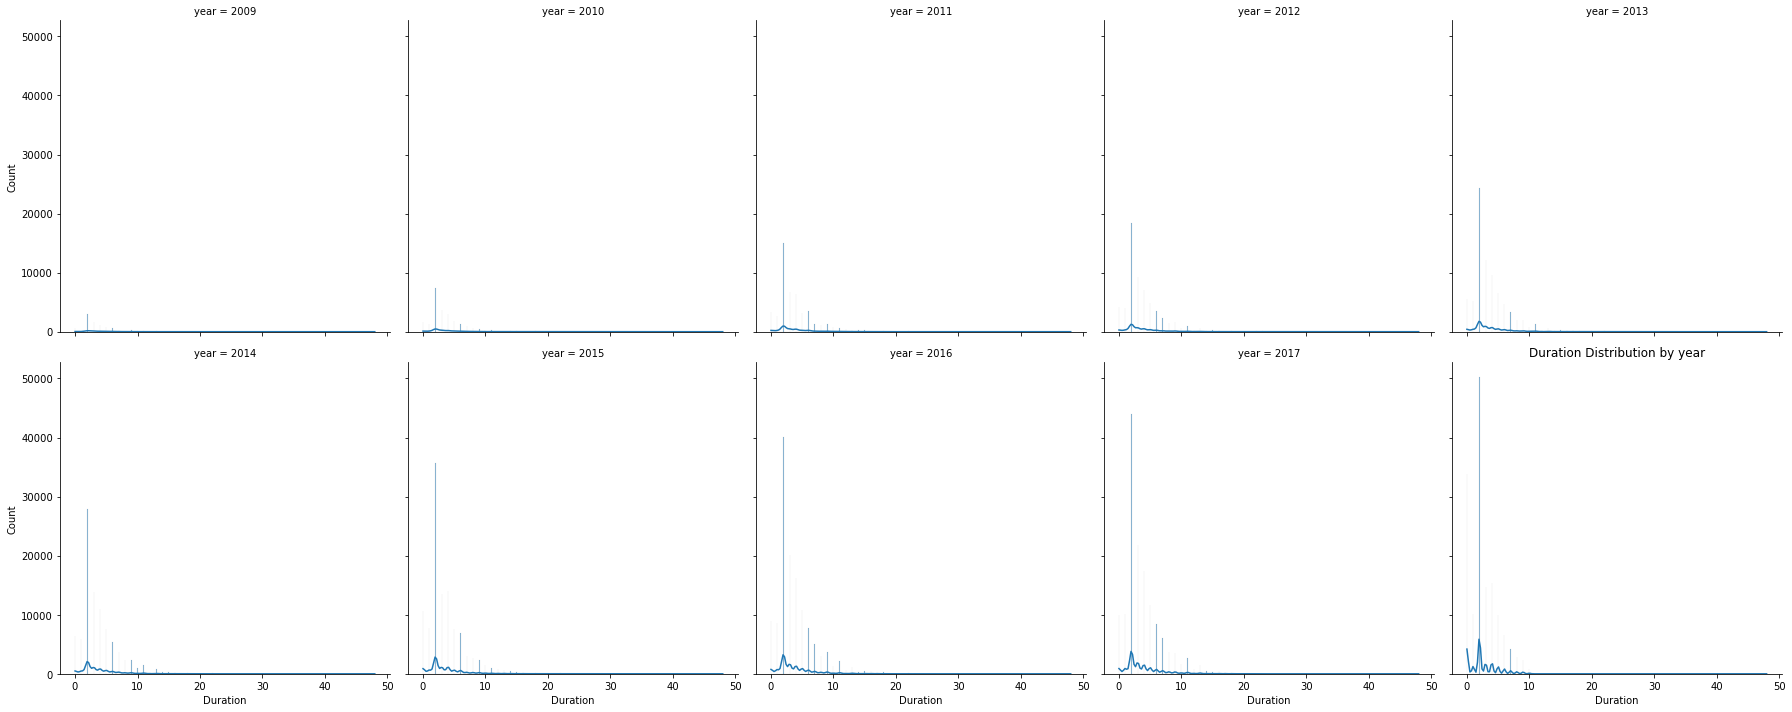

In [94]:
#Duration distribution by year graph
def duration_dis_plot():
    duration= duration_calc(subscriptions_duration)
    duration['year']=duration['Join Date'].dt.year
    sns.displot(duration, x="Duration",kde=True, col='year',col_wrap=5)
    plt.title('Duration Distribution by year')
    plt.show()

duration_dis_plot()

2009-05-01 00:00:00


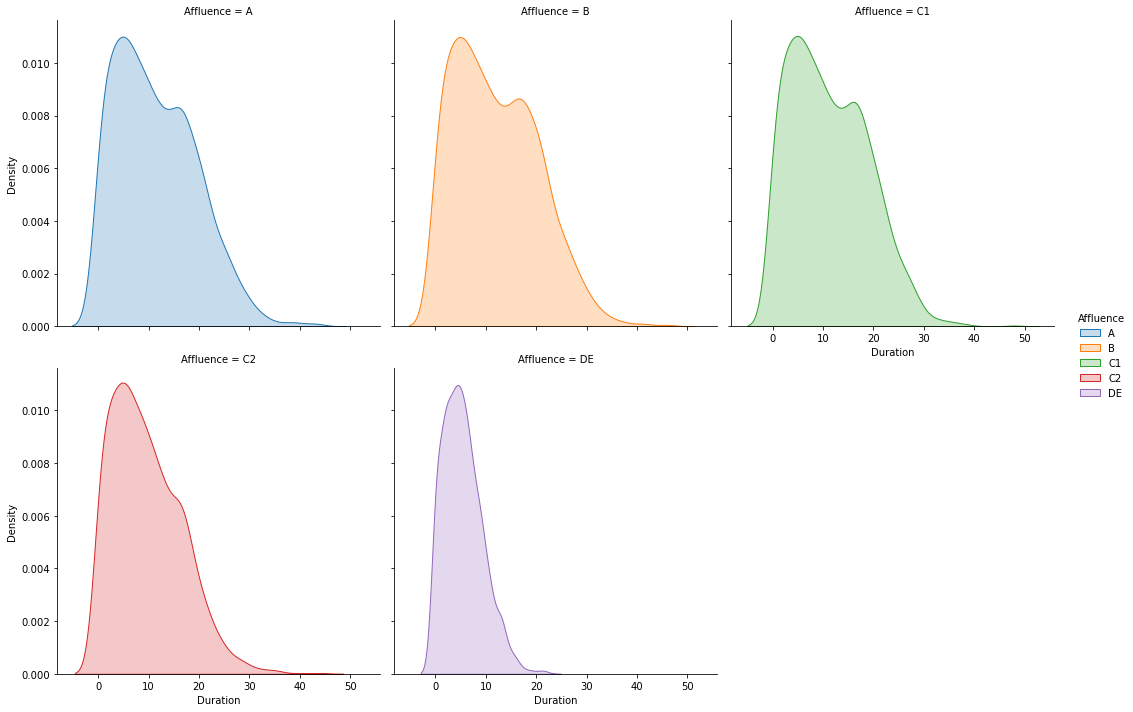

In [95]:
def duration_affluence_plot():
    duration= duration_calc(subscriptions_duration)
    duration= subscriptions_duration.groupby(['Join Date', 'Duration','Affluence']).size().to_frame('Count').reset_index()
    sns.displot(duration, x="Duration",col= "Affluence",hue='Affluence',col_wrap=3,kind="kde", fill=True)
    
duration_affluence_plot()

In [ ]:
def duration_gender_plot():
    duration= duration_calc(subscriptions_duration)
    duration= subscriptions_duration.groupby(['Join Date', 'Duration','Gender']).size().to_frame('Count').reset_index()
    sns.displot(duration, x="Duration",hue='Gender',kind="kde", fill=True)
    plt.title('Duration Distribution by Gender')

duration_gender_plot()

In [ ]:
def duration_subscription_type_plot():
    duration= duration_calc(subscriptions_duration)
    duration= subscriptions_duration.groupby(['Join Date', 'Duration','Subscription Type']).size().to_frame('Count').reset_index()
    sns.displot(duration, x="Duration",hue='Subscription Type',kind="kde", fill=True)
    plt.title('Duration Distribution by Subscription Type')

duration_subscription_type_plot()

## Monthly visitations by season

In [ ]:
#Merging the visitation and subscriptions data together
def merging_data():
    visit1=visitation_part1#.copy()
    visit2=visitation_part2#.copy()
    visitdf = pd.concat([visit1, visit2], axis=0, join='inner')
    all_data= pd.merge( left= subscriptions, right= visitdf, left_on='CustomerID', right_on='CustomerID')
    all_data['visitdate'] =  pd.to_datetime(all_data['visitdate'].str.upper(), format='%Y/%m/%d', yearfirst=False)
    all_data['month'] = all_data['visitdate'].dt.month
    return all_data

In [ ]:
#Classifying season
def classify_season(month):
    if  month==6 or month==7 or month==8:
        return 'Summer'
    elif month==9 or month==10 or month==11:
        return 'Autumn'
    elif month==12 or month==1 or month==2:
        return 'Winter'
    else:
        return 'Spring'

In [ ]:
# Plot for monthly visitations by season:
def plot_season():
    all_data = merging_data()
    all_data['Season'] = all_data['month'].apply(lambda x : classify_season(x))
    freq=all_data.groupby(['CustomerID','month','Season']).size().to_frame('Monthly Visits').reset_index()
    sns.displot(freq, x="Monthly Visits",hue='Season',kind="kde", bw_adjust=1.5, fill=True)
    plt.title('Monthly Visitation Distribution by Season')
    
plot_season()

## Customer Profile

In [ ]:
#Calculating active members
def active_members(subscr_data):
    subscriptions = subscr_data

    subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
    subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)

    date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
    date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )

    all_dates = pd.date_range(date_min, date_max, freq = 'Y')
    subscriptions['End Date'] = subscriptions['End Date'].fillna(date_max)
    subscriptions[all_dates] = pd.concat([((subscriptions['Join Date'] <= i) &
                                           (i <= subscriptions['End Date'])).astype(int) for i in all_dates], axis=1)
    return subscriptions    

In [ ]:
#Classigying age
def classify_age(age):
    if   18 <=age<=24:
        return '18-24'
    elif 25<= age <=30:
        return '25-30'
    elif 31 <= age <= 40:
        return '31-40'
    else:
        return '41-60'

#Data for plotting active members by age 
def customer_age_data():
    df = active_members(subscriptions)
    df['age'] = df['Join Date'] - df['BirthYear']   
    df['agerange'] = df['age'].apply(lambda x : classify_age(x))
    date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
    date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
    all_dates = pd.date_range(date_min, date_max, freq = 'Y')
    df_age=df.groupby('agerange')[all_dates].sum().T
    df_age1=df_age.reset_index()
    df_age1['year'] = df_age1['index'].dt.year
    df_age2=df_age1.drop(columns=('index'), axis=1)
    plot_age=df_age2.set_index('year')
    plot_age['age:18-24']=plot_age['18-24'] / plot_age.sum(axis=1)
    plot_age['age:25-30']=plot_age['25-30'] / plot_age.sum(axis=1)
    plot_age['age:31-40']=plot_age['31-40'] / plot_age.sum(axis=1)
    plot_age['age:41-60']=plot_age['41-60'] / plot_age.sum(axis=1)
    return plot_age

# active members by age plot
def customer_age_plot():
    plot_age= customer_age_data()
    plot_age.loc[:,['age:18-24','age:25-30','age:31-40', 'age:41-60']].plot.bar(stacked=True, figsize=(10,7))
    leg = plt.legend( loc = 'upper right')
    plt.title('Active Members by age')
    
customer_age_plot()

In [ ]:
#Data for plotting active members by Gender:
def customer_gender_data():
    subs_data = subscriptions.copy()
    df = active_members(subs_data)
        
    date_min = min (subs_data['Join Date'].min(),subs_data['End Date'].min() )
    date_max = max (subs_data['Join Date'].max(),subs_data['End Date'].max() )
    all_dates = pd.date_range(date_min, date_max, freq = 'Y')
    df_g=df.groupby('Gender')[all_dates].sum().T
    df_g1=df_g.reset_index()
    df_g1['year'] = df_g1['index'].dt.year
    df_g2=df_g1.drop(columns=('index'), axis=1)
    plot_g=df_g2.set_index('year')
    plot_g['female']=plot_g['Female'] / plot_g.sum(axis=1)
    plot_g['male']=plot_g['Male'] / plot_g.sum(axis=1)
    return plot_g


# active members by gender plot
def customer_gender_graph():
    plot_g= customer_gender_data()
    plot_g.loc[:,['female','male']].plot.bar(stacked=True, figsize=(10,7))
    leg = plt.legend( loc = 'upper right')
    plt.title('Active Members by Gender')
    
customer_gender_graph()

In [ ]:
# active members by afflunce plot:
def customer_affluence_data():
    subs_data = subscriptions.copy()
    df=active_members(subs_data)
    date_min = min (subs_data['Join Date'].min(),subs_data['End Date'].min() )
    date_max = max (subs_data['Join Date'].max(),subs_data['End Date'].max() )
    all_dates = pd.date_range(date_min, date_max, freq = 'Y')
    df_a=df.groupby('Affluence')[all_dates].sum().T
    df_a1=df_a.reset_index()
    df_a1['year'] = df_a1['index'].dt.year
    df_a2=df_a1.drop(columns=('index'), axis=1)
    plot_a=df_a2.set_index('year')
    plot_a['a']=plot_a['A'] / plot_a.sum(axis=1)
    plot_a['b']=plot_a['B'] / plot_a.sum(axis=1)
    plot_a['c1']=plot_a['C1'] / plot_a.sum(axis=1)
    plot_a['c2']=plot_a['C2'] / plot_a.sum(axis=1)
    plot_a['de']=plot_a['DE'] / plot_a.sum(axis=1)
    return plot_a

def customer_affluence_graph():
    plot_a= customer_affluence_data()
    plot_a.loc[:,['a','b','c1','c2','de']].plot.bar(stacked=True, figsize=(10,7))
    leg = plt.legend( loc = 'upper right')
    plt.title('Active Members by Affluence')

customer_affluence_graph()

In [ ]:
# active members by subscription type plot:
def customer_sub_type_data():
    subs_data = subscriptions.copy()

    df=active_members(subs_data)
    date_min = min (subs_data['Join Date'].min(),subs_data['End Date'].min() )
    date_max = max (subs_data['Join Date'].max(),subs_data['End Date'].max() )
    all_dates = pd.date_range(date_min, date_max, freq = 'Y')
    df_c=df.groupby('Subscription Type')[all_dates].sum().T
    df_c1=df_c.reset_index()
    df_c1['year'] = df_c1['index'].dt.year
    df_c2=df_c1.drop(columns=('index'), axis=1)
    plot_c=df_c2.set_index('year')
    plot_c['standard']=plot_c['Standard'] / plot_c.sum(axis=1)
    plot_c['flexible']=plot_c['Flexible'] / plot_c.sum(axis=1)
    return plot_c


# active members by subscriptiontype plot
def customer_sub_type_graph():
    plot_c= customer_sub_type_data()
    plot_c.loc[:,['standard','flexible']].plot.bar(stacked=True, figsize=(10,7))
    leg = plt.legend( loc = 'upper right')
    plt.title('Active Members by Subscription Type')
    
customer_sub_type_graph()

### Number of clubs overitme

In [ ]:
def number_of_clubs():
    subs_data = subscriptions.copy()

    df=active_members(subs_data)
    df['year'] = df['Join Date'].dt.year
    df11=df.groupby(['Club','year']).size().to_frame('Count').reset_index()
    df_club=df11.groupby(['Club','year']).size().to_frame('Count').reset_index()
    pivotdata = df_club.pivot(index= 'year', columns='Club', values='Count')
    pivotdata["sum"] = pivotdata.sum(axis=1)
    plotdata=pivotdata.reset_index()
    return plotdata

def club_plot():
    plotdata= number_of_clubs()
    plotdata.plot.bar(x='year', y='sum', figsize=(10,7))
    plt.title('Number of Clubs Over Time')
    
club_plot()